In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras import layers

In [2]:
df = pd.read_csv('D:\spam.csv',encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df.shape

(5572, 5)

In [4]:
df['Unnamed: 2'].value_counts

<bound method IndexOpsMixin.value_counts of 0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
5567    NaN
5568    NaN
5569    NaN
5570    NaN
5571    NaN
Name: Unnamed: 2, Length: 5572, dtype: object>

In [5]:
df['Unnamed: 2'].isnull().sum()

5522

In [6]:
df['Unnamed: 4'].isnull().sum()

5566

In [7]:
df = df.drop(['Unnamed: 4','Unnamed: 3','Unnamed: 2'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})

In [8]:
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


<Axes: xlabel='label', ylabel='count'>

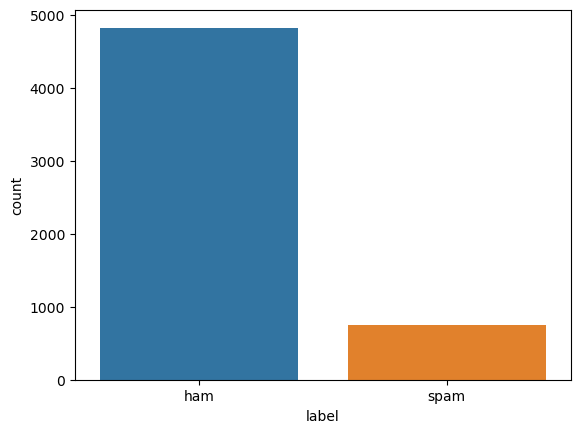

In [9]:
sns.countplot(data=df,x =df['label'])

In [10]:
#ham_msg = df[df.label_enc == 0]
#spam_msg = df[df.label_enc == 1]
#ham_msg = ham_msg.sample(n = len(spam_msg),random_state=42)

In [11]:
#spam_msg

In [12]:
#ham_msg

In [13]:
#balanced_data = ham_msg.append(spam_msg)\
 #   .reset_index(drop=True)

In [14]:
#balanced_data

In [15]:
#sns.countplot(data = balanced_data,x = balanced_data['label'])

In [16]:
avg_words_len = round(sum([len(i.split()) for i in df['Text']]) / len(df['Text']))
avg_words_len

15

In [17]:
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [18]:
s = set()
for sent in df['Text']:
    for word in sent.split():
        s.add(word)
total_words_length=len(s)
print(total_words_length)

15585


In [19]:
from sklearn.model_selection import train_test_split
X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score
 
tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec , X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)
baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

In [21]:
print(classification_report(y_test,baseline_model.predict(X_test_vec)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



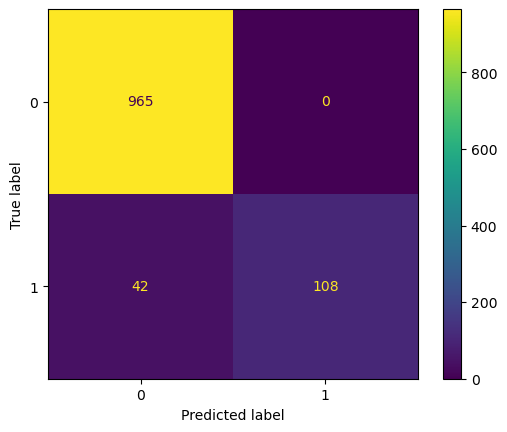

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, baseline_model.predict(X_test_vec))
disp = ConfusionMatrixDisplay(confusion_matrix = cm )
disp.plot()

In [24]:
from tensorflow.keras.layers import TextVectorization
MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len
 
text_vec = TextVectorization(max_tokens=MAXTOKENS,standardize='lower_and_strip_punctuation',
                             output_mode='int',
                             output_sequence_length=OUTPUTLEN)
text_vec.adapt(X_train)

In [25]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

In [26]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)

vec_layer = text_vec(input_layer)

embedding_layer_model = embedding_layer(vec_layer)

x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

model_1 = keras.Model(input_layer, output_layer)
model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5), metrics=['accuracy'])

In [27]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [28]:
history_1 =model_1.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test),validation_steps=int(0.2*len(X_test)))

Epoch 1/5
140/140 [==============================] - 4s 22ms/step - loss: 0.6022 - accuracy: 0.9186 - val_loss: 0.5773 - val_accuracy: 0.9767
Epoch 2/5
140/140 [==============================] - 3s 19ms/step - loss: 0.5701 - accuracy: 0.9879 - val_loss: 0.5733 - val_accuracy: 0.9821
Epoch 3/5
140/140 [==============================] - 3s 20ms/step - loss: 0.5657 - accuracy: 0.9953 - val_loss: 0.5726 - val_accuracy: 0.9839
Epoch 4/5
140/140 [==============================] - 3s 20ms/step - loss: 0.5642 - accuracy: 0.9982 - val_loss: 0.5722 - val_accuracy: 0.9848
Epoch 5/5
140/140 [==============================] - 3s 20ms/step - loss: 0.5635 - accuracy: 0.9993 - val_loss: 0.5724 - val_accuracy: 0.9830


<Axes: >

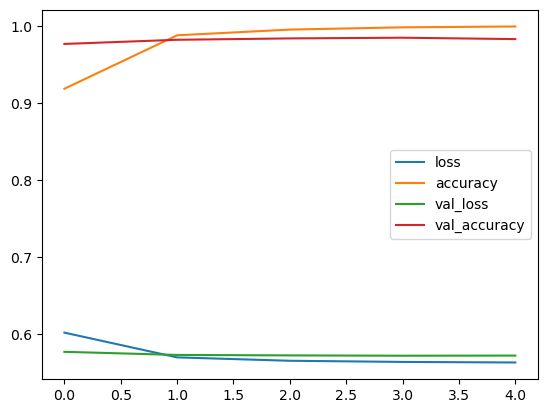

In [29]:
pd.DataFrame(history_1.history).plot()